In [1]:
import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

from gradvi.tests import toy_priors
from gradvi.tests import toy_data
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma
from gradvi.inference import Trendfiltering
from mrashpen.utils import R_trendfilter

def saveplot(fig, fileprefix, ext = 'png', plotdir = 'plots'):
    filename = f"{plotdir}/{fileprefix}.{ext}"
    fig.savefig(filename, bbox_inches = 'tight')
    return

plotprefix = 'simple'

In [2]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degrees = [0, 1, 2]
nknots  = 4
strue = 0.1
knots = np.linspace(0, 1, nknots+2)[1:-1]

data = dict()

for degree in degrees:
    data[degree] = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

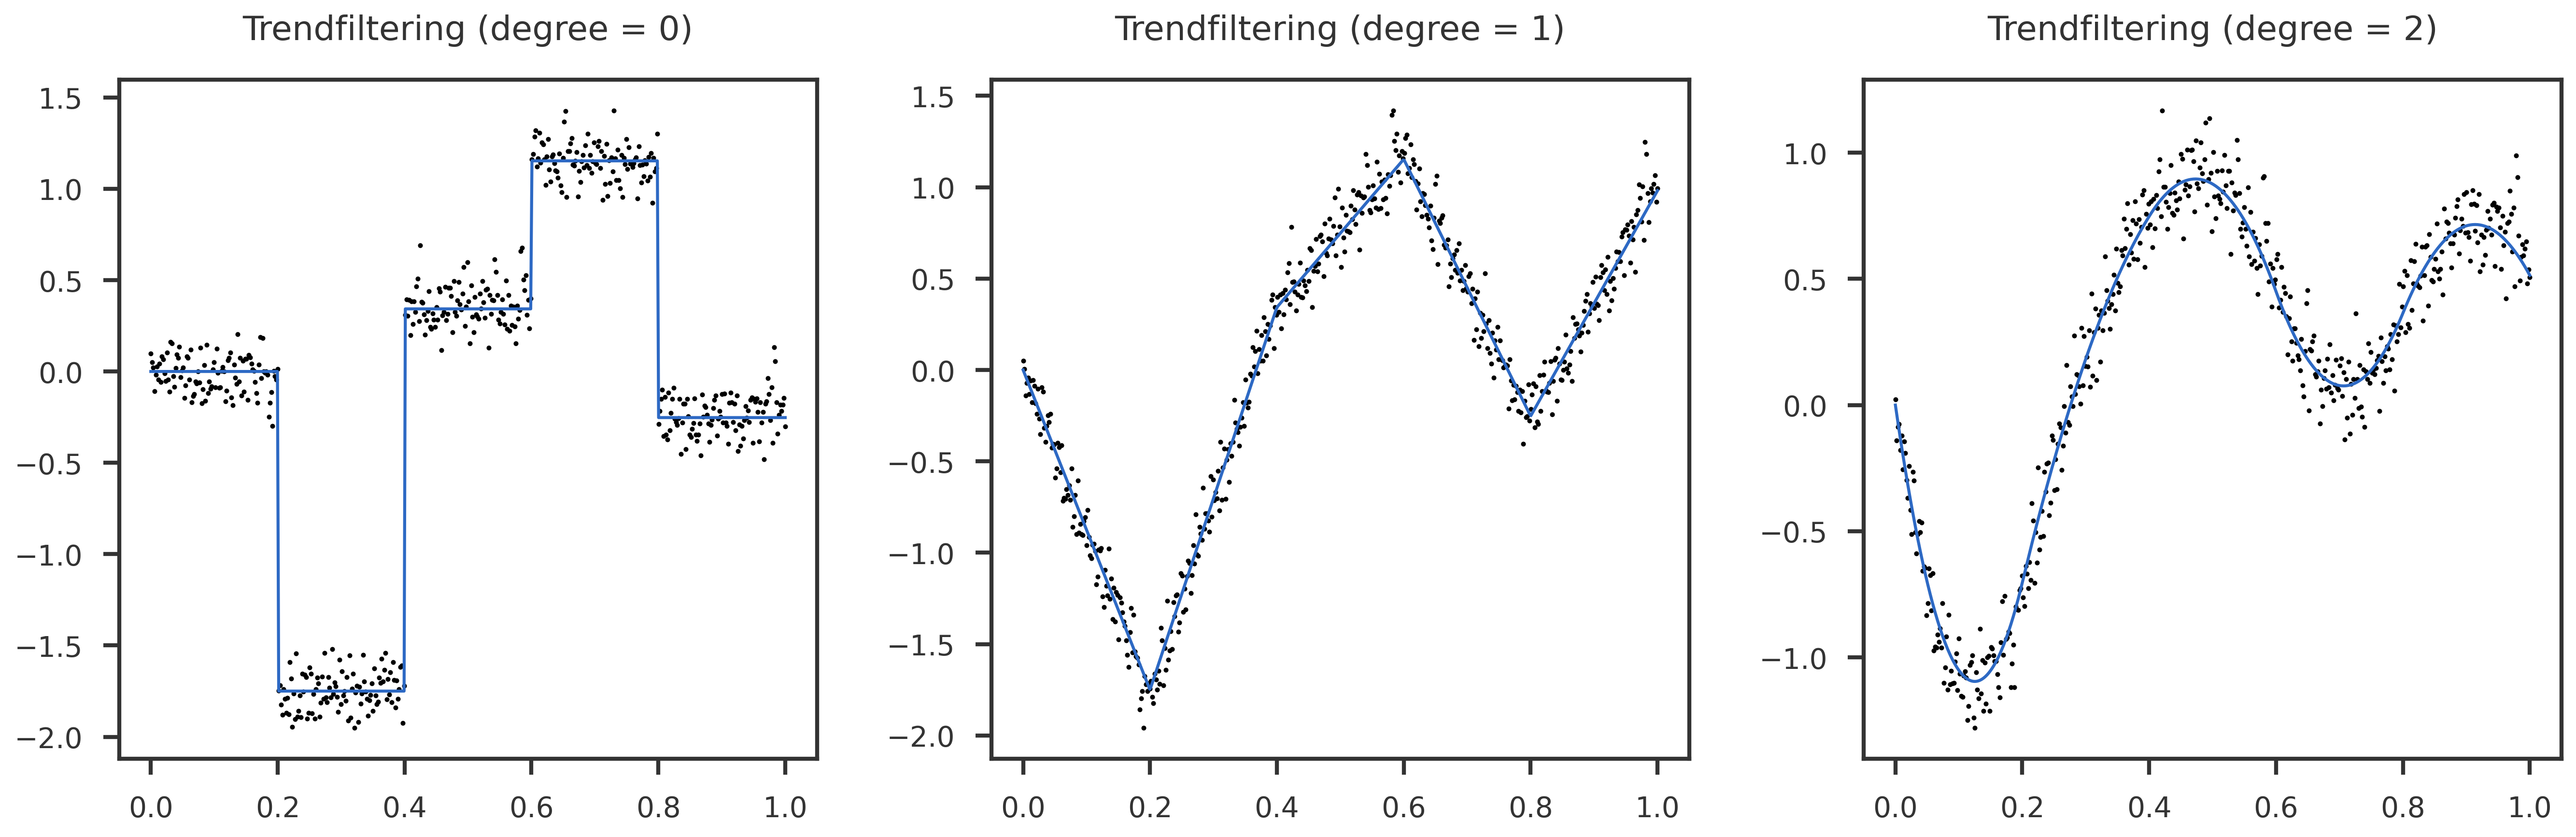

In [3]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue)
    #ax.plot(data[d].x, gvma.moving_average(data[d].y))
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)

    
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples')
plt.show()

In [5]:
gv = dict()
gl_ypred = dict()

for dk, dt in data.items():
    print (f"Degree {dk}. Running genlasso.")
    tf_y, tf_fit = R_trendfilter.fit(dt.y, order = dk)
    gl_ypred[dk] = tf_y 
    prior_init = toy_priors.get_ash(k = 20, sparsity = 0.9, skbase = 2.0, skfactor = 10.0)
    gv[dk] = Trendfiltering(maxiter = 20000, standardize_basis = False, standardize = True)
    gv[dk].fit(dt.y, dk, prior_init, y_init = tf_y)
    print (f"GradVI terminated after {gv[dk].niter} iterations.")

Degree 0. Running genlasso.


R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

GradVI terminated after 3753 iterations.
Degree 1. Running genlasso.
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

GradVI terminated after 2097 iterations.
Degree 2. Running genlasso.
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

GradVI terminated after 147 iterations.


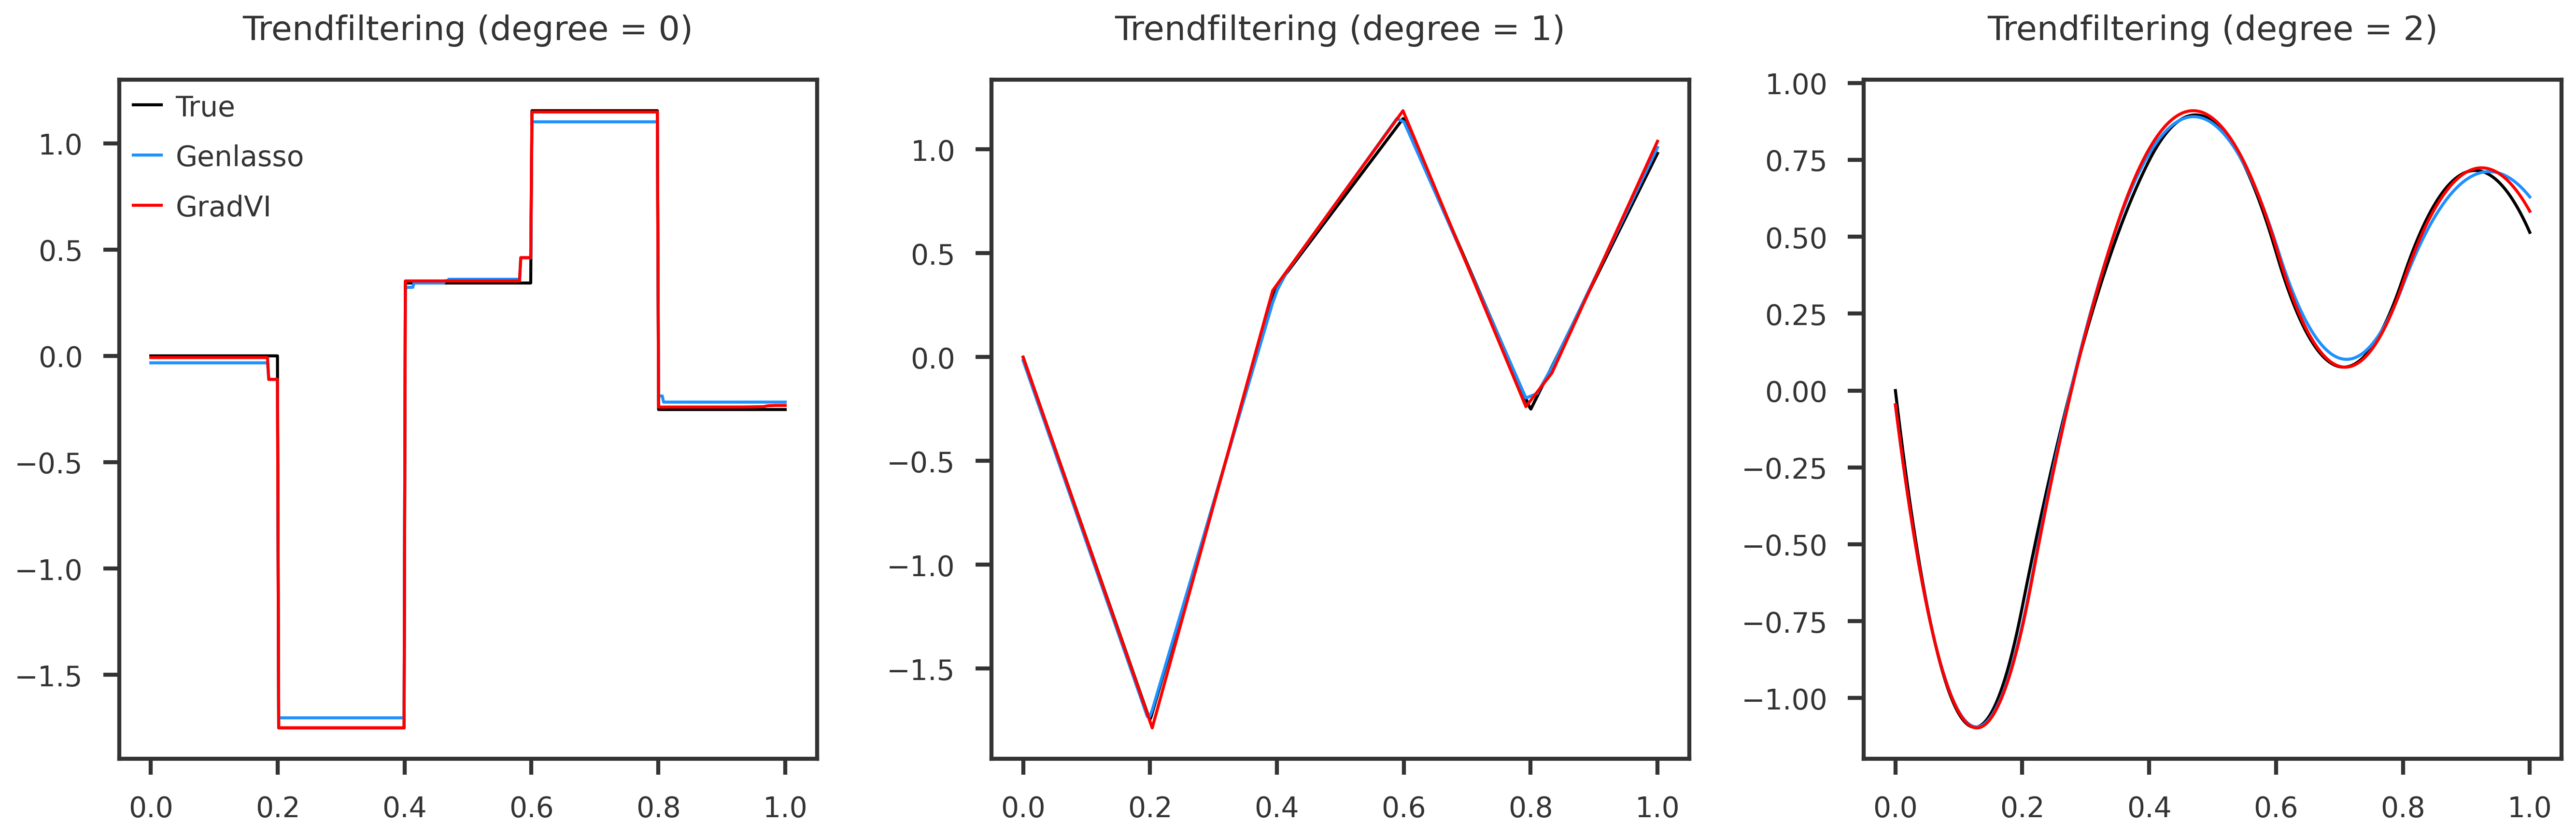

In [9]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    ax = fig.add_subplot(1, 3, i+1)
    #ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue, label = 'True', color = 'black')
    ax.plot(data[d].x, gl_ypred[d], label = 'Genlasso', color = 'dodgerblue')
    ax.plot(data[d].x, gv[d].ypred, label = 'GradVI', color = 'red')
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
    
    if d == 0:
        ax.legend()
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples')
plt.show()

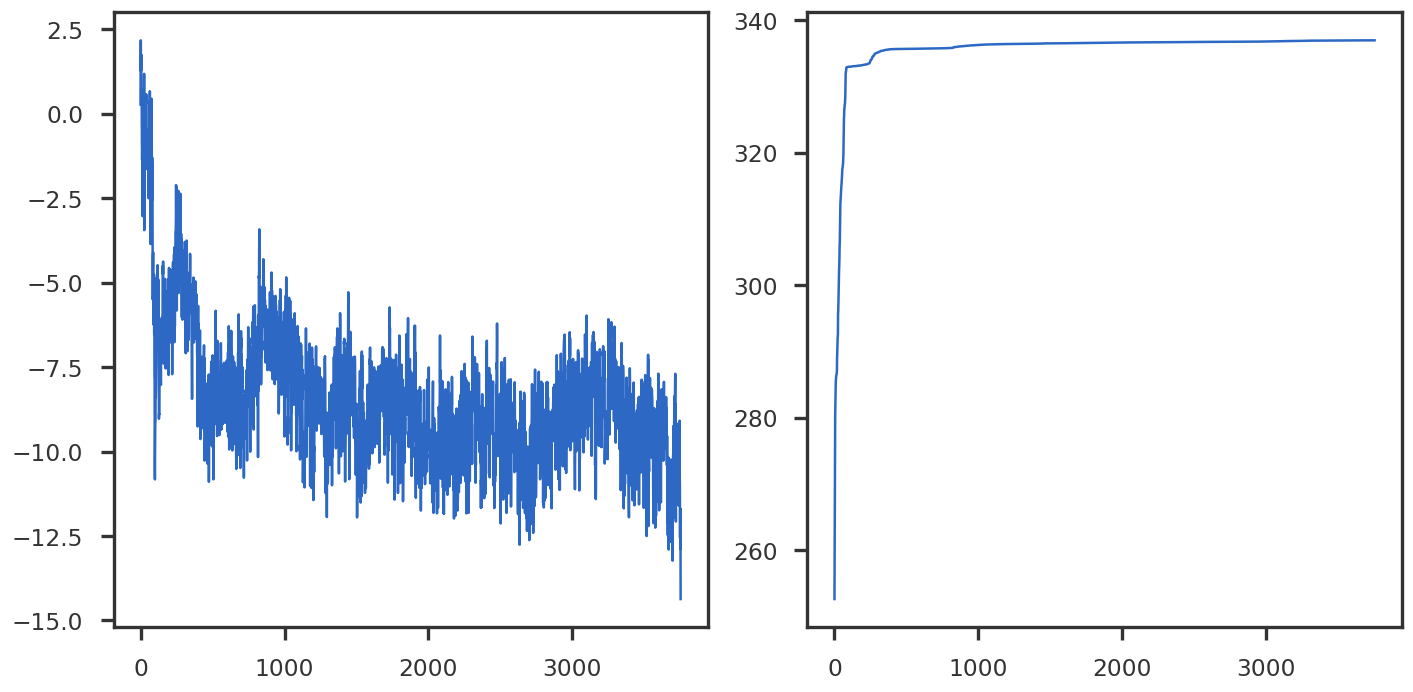

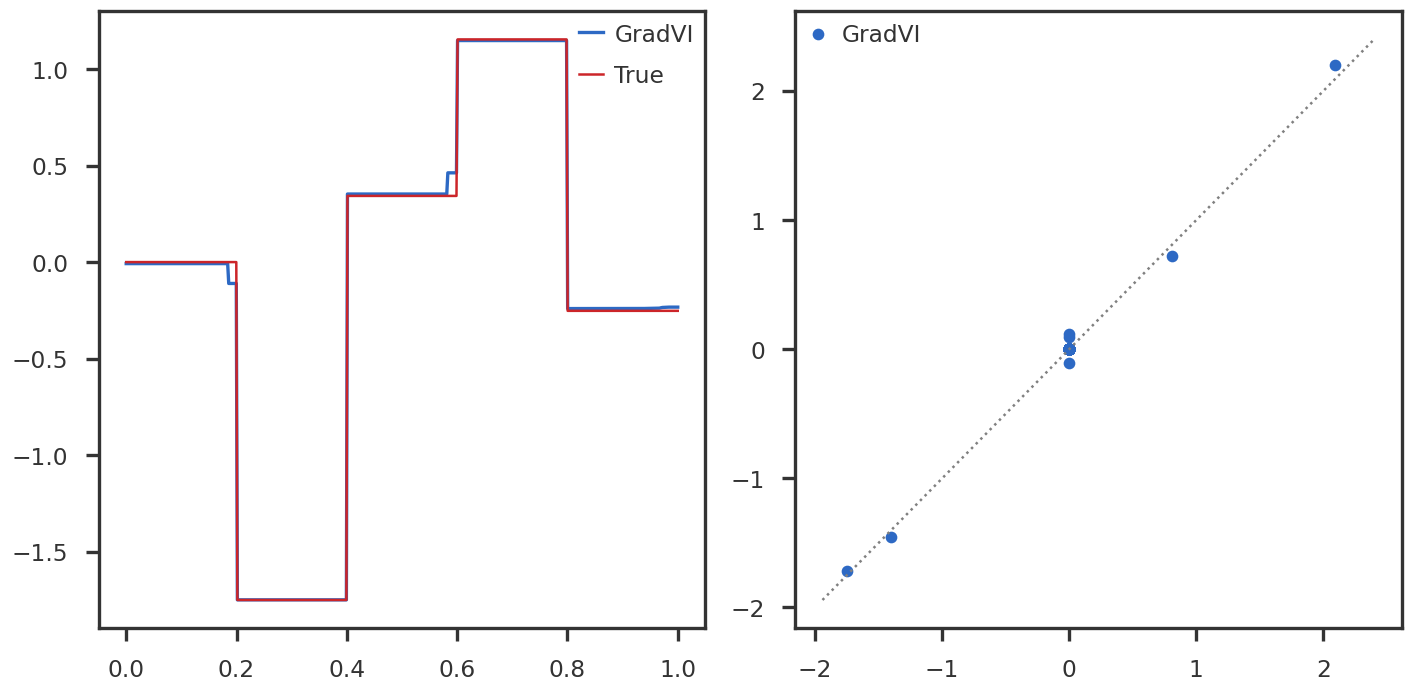

In [11]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

fig = plt.figure(figsize = (12, 6))

dk = 0

log_objdiff = np.log(-np.diff(gv[dk].obj_path))
log_objpath = np.log(gv[dk].obj_path[:gv[dk].niter - 1] - gv[dk].obj_path[gv[dk].niter-1])

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(np.arange(gv[dk].niter - 1), log_objdiff)
ax2.plot(np.arange(gv[dk].niter - 1), -gv[dk].elbo_path[1:])

fig.tight_layout()
plt.show()

fig = plt.figure(figsize = (12, 6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(data[dk].x, gv[dk].ypred, lw = 2, label = 'GradVI')
ax1.plot(data[dk].x, data[dk].ytrue, label = 'True')

ax2.scatter(data[dk].btrue, gv[dk].coef, label = 'GradVI')
mpl_utils.plot_diag(ax2)

ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()